In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
ft.__version__

'0.6.0'

# About
This is a notebook which shows how we can create an EntitySet from a dataset with the DataShop structure. The content of this notebook, the function `datashop_to_entityset`, is also in [utilities](utilities.py) so that it can be loaded as a package in the [demo](Demo%20-%20DataShop.ipynb) notebook.

In [2]:
import featuretools.variable_types as vtypes
def datashop_to_entityset(filename):
    # Make an EntitySet called Dataset with the following structure
    #
    # schools       students     problems
    #        \        |         /
    #   classes   sessions   problem steps
    #          \     |       /
    #           transactions  -- attempts
    #

    # Convert the csv into a dataframe using pandas
    data = pd.read_csv(filename, '\t')

    # Make the Transaction Id the index column of the dataframe and clean other columns
    data.index = data['Transaction Id']
    data = data.drop(['Row'], axis=1)
    data['Outcome'] = data['Outcome'].map({'INCORRECT': 0, 'CORRECT': 1})

    # Make a new 'End Time' column which is start_time + duration
    # This is /super useful/ because you shouldn't be using outcome data at
    # any point before the student has attempted the problem.
    data['End Time'] = pd.to_datetime(data['Time']) + pd.to_timedelta(pd.to_numeric(data['Duration (sec)']), 's')

    # Make a list of all the KC and CF columns present
    kc_and_cf_cols = [x for x in data.columns if (x.startswith('KC ') or x.startswith('CF '))]

    # Now we start making an entityset. We make 'End Time' a time index for 'Outcome'
    # even though our primary time index for a row is 'Time' preventing label leakage.
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(entity_id='transactions',
                             index='Transaction Id',
                             dataframe=data,
                             variable_types={'Outcome': vtypes.Boolean},
                             time_index='Time',
                             secondary_time_index={'End Time': ['Outcome', 'Is Last Attempt', 'Duration (sec)']})

    # Every transaction has a `problem_step` which is associated to a problem
    es.normalize_entity(base_entity_id='transactions',
                        new_entity_id='problem_steps',
                        index='Step Name',
                        additional_variables=['Problem Name'],
                        make_time_index=False)

    es.normalize_entity(base_entity_id='problem_steps',
                        new_entity_id='problems',
                        index='Problem Name',
                        make_time_index=False)

    # Every transaction has a `session` associated to a student
    es.normalize_entity(base_entity_id='transactions',
                        new_entity_id='sessions',
                        index='Session Id',
                        additional_variables=['Anon Student Id'],
                        make_time_index=True)

    es.normalize_entity(base_entity_id='sessions',
                        new_entity_id='students',
                        index='Anon Student Id',
                        make_time_index=True)

    # Every transaction has a `class` associated to a school
    es.normalize_entity(base_entity_id='transactions',
                        new_entity_id='classes',
                        index='Class',
                        additional_variables=['School'],
                        make_time_index=False)

    es.normalize_entity(base_entity_id='classes',
                        new_entity_id='schools',
                        index='School',
                        make_time_index=False)

    # And because we might be interested in creating features grouped
    # by attempts we normalize by those as well.
    es.normalize_entity(base_entity_id='transactions',
                        new_entity_id='attempts',
                        index='Attempt At Step',
                        additional_variables=[],
                        make_time_index=False)
    return es

In [3]:
filename = 'data/ds76_tx_All_Data_74_2018_0912_070949.txt'
es = datashop_to_entityset(filename)
es

Entityset: Dataset
  Entities:
    transactions [Rows: 6778, Columns: 179]
    problem_steps [Rows: 78, Columns: 2]
    problems [Rows: 20, Columns: 1]
    sessions [Rows: 59, Columns: 3]
    students [Rows: 59, Columns: 2]
    classes [Rows: 1, Columns: 2]
    schools [Rows: 1, Columns: 1]
    attempts [Rows: 9, Columns: 1]
  Relationships:
    transactions.Step Name -> problem_steps.Step Name
    problem_steps.Problem Name -> problems.Problem Name
    transactions.Session Id -> sessions.Session Id
    sessions.Anon Student Id -> students.Anon Student Id
    transactions.Class -> classes.Class
    classes.School -> schools.School
    transactions.Attempt At Step -> attempts.Attempt At Step

# Summary
In total we have made 8 entities. At the base is `transactions` and then we have the following one-to-many relationships which have a one-to-many with `transactions`:
1. `problems` -> `problem_steps` -> `transactions`  
2. `students` -> `sessions`  -> `transactions`
3. `schools` -> `classes` -> `transactions`
4. `attempts` -> `transactions`

Our base entity also has a time index `Time` and a secondary time index `End Time` for columns which can only be known when the event is over. This allows us to use `Outcome` in our feature matrix, since it will only be used for later events.

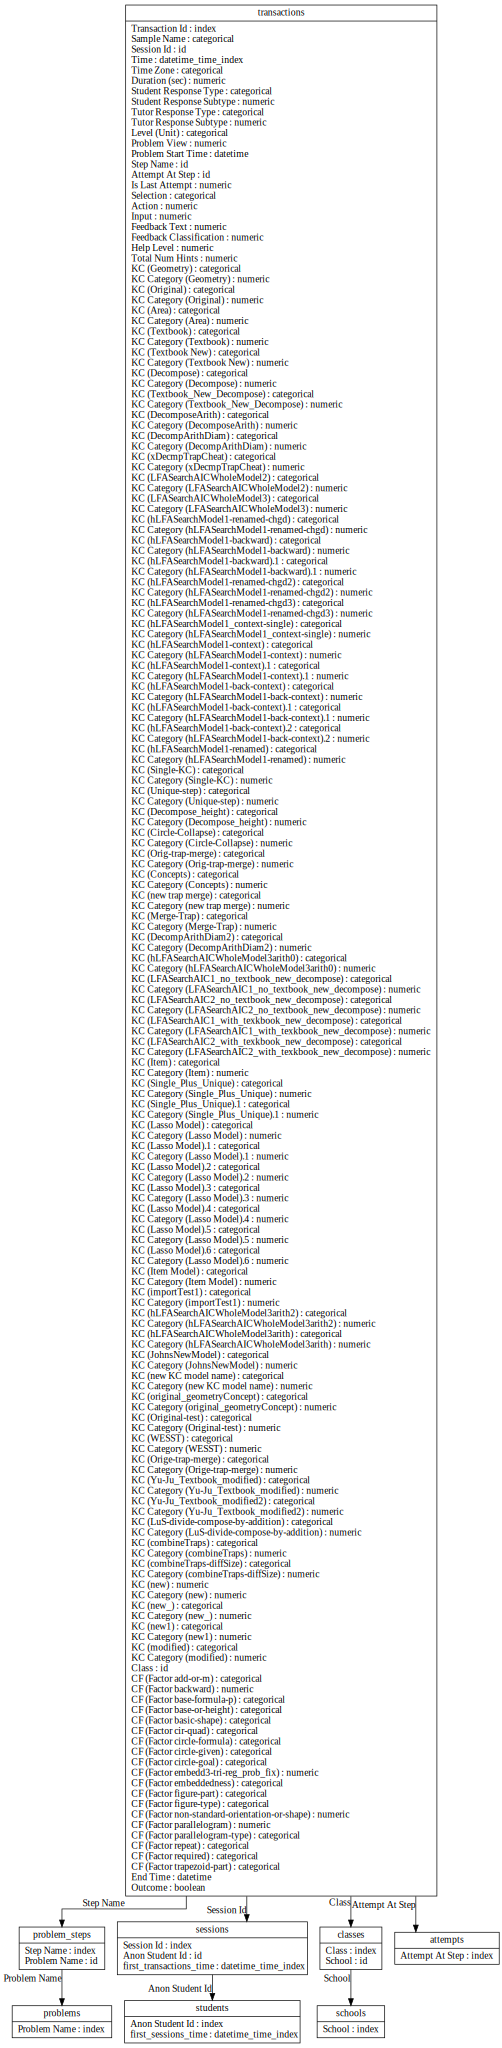

In [4]:
es.plot()

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).